In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display 
from sklearn.metrics import fbeta_score
import model_utils as model_utils
from sklearn.externals import joblib

import json
# Pretty display for notebooks
%matplotlib inline
pd.set_option('display.max_colwidth', -1)


with open('best_config.json') as json_data_file:
    config = json.load(json_data_file)[0]
print(config)
seed = int(config['seed'])
test_size = config['test_size']

dataset = pd.read_csv("datasets/encoded_dataset.csv")
display(dataset.head(n = 5))

labels = dataset[['RIESGO_VIDA']]
features = dataset.drop(['RIESGO_VIDA'], axis = 1)


{u'test_size': 0.1, u'seed': 134.0, u'impute': 0.0}


,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM,RIESGO_VIDA
0,0.413632,0.457947,0.404291,0.422006,0.43569,0.411426,0.498799,0.425020,0.488333,0.436371,...,0.388499,0.416195,0.420014,0.271184,0.168226,0.457652,0.266635,0.456139,0.4024,0
1,0.367341,0.457947,0.447575,0.455866,0.43569,0.371084,0.459542,0.425020,0.420733,0.436371,...,0.388499,0.375220,0.366720,0.433927,0.281359,0.457652,0.459141,0.456139,0.4024,0
2,0.557791,0.457947,0.488072,0.455866,0.43569,0.564257,0.532725,0.425020,0.420733,0.436371,...,0.388499,0.549517,0.558897,0.433927,0.616036,0.457652,0.459141,0.456139,0.4024,0
3,0.409106,0.457947,0.404291,0.455866,0.43569,0.445723,0.532725,0.526102,0.420733,0.436371,...,0.450952,0.407647,0.447220,0.433927,0.616036,0.457652,0.459141,0.456139,0.4024,1
4,0.413632,0.457947,0.404291,0.455866,0.43569,0.411426,0.498799,0.425020,0.488333,0.436371,...,0.388499,0.416195,0.420014,0.271184,0.168226,0.457652,0.266635,0.456139,0.4024,0


In [2]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'labels' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = test_size, random_state = seed, stratify=labels)

# Show the results of the split
print "features_final set has {} samples.".format(features.shape[0])
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])


features_final set has 281311 samples.
Training set has 253179 samples.
Testing set has 28132 samples.


In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Initialize the three models
clf_A = GaussianNB()
clf_B = RandomForestClassifier(random_state = seed)
clf_C = AdaBoostClassifier(random_state = seed)


# Collect results on the learners
dfResults = pd.DataFrame(columns=['learner', 'train_time', 'pred_time', 'f_test', 'f_train'])

for k, clf in enumerate([clf_A, clf_B, clf_C]):
    clf_name = clf.__class__.__name__  
    clf, dfResults = model_utils.train_predict(clf, 1, X_train, y_train, X_test, y_test, dfResults)


/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB trained.


/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
model_utils.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  learner = learner.fit(X_train, y_train)


RandomForestClassifier trained.
AdaBoostClassifier trained.


In [4]:
display( dfResults.sort_values(by=['f_test'], ascending = False)[['learner', 'f_test']])


,learner,f_test
1,RandomForestClassifier,0.814292
2,AdaBoostClassifier,0.794202
0,GaussianNB,0.655431


# Tuning Models

## Tuning RandomForestClassifier

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Unoptimized model
------
F-score on testing data: 0.7980

Optimized Model
------
Final F-score on the testing data: 0.8564


['rf_classifier.joblib']

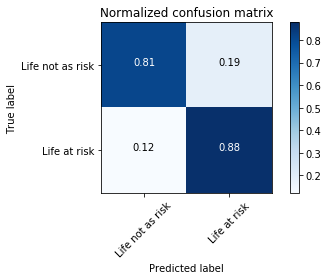

In [5]:
from sklearn.metrics import make_scorer

rf_classifier = RandomForestClassifier(random_state = seed)

rfParameters = {    
  'criterion':['gini', 'entropy'],
  'max_depth':[5, 10, 15, 30],
  'max_features':['auto', 'sqrt', 'log2', None],
  'class_weight': ['balanced', 'balanced_subsample'], 
}

rf_classifier, default_rf_score, tuned_rf_score, cnf_rf_matrix = model_utils.tune_classifier(rf_classifier, rfParameters, X_train, X_test, y_train, y_test)

model_utils.plot_confusion_matrix(cnf_rf_matrix, classes=['Life not as risk', 'Life at risk'], normalize = True)
print "Unoptimized model\n------"
print "F-score on testing data: {:.4f}".format(default_rf_score)
print "\nOptimized Model\n------"
print "Final F-score on the testing data: {:.4f}".format(tuned_rf_score)
joblib.dump(rf_classifier, 'rf_classifier.joblib') 


## Tuning AdaBoostClassifier

Unoptimized model
------
F-score on testing data: 0.7837

Optimized Model
------
Final F-score on the testing data: 0.7837


['ada_classifier.joblib']

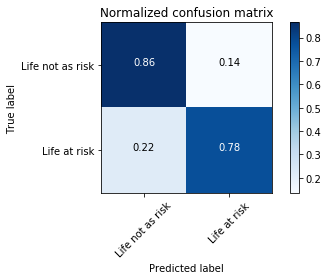

In [6]:
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier(random_state = seed)

adaParameters = {
  'learning_rate':[0.1, 0.5, 1],
  'algorithm' :['SAMME', 'SAMME.R']
}

ada_classifier, default_ada_score, tuned_ada_score, cnf_ada_matrix = model_utils.tune_classifier(ada_classifier, adaParameters,  X_train, X_test, y_train, y_test)

model_utils.plot_confusion_matrix(cnf_ada_matrix, classes=['Life not as risk', 'Life at risk'], normalize = True)
print "Unoptimized model\n------"
print "F-score on testing data: {:.4f}".format(default_ada_score)
print "\nOptimized Model\n------"
print "Final F-score on the testing data: {:.4f}".format(tuned_ada_score)

joblib.dump(ada_classifier, 'ada_classifier.joblib') 


## Tuning GaussianClassifier


Unoptimized model
------
F-score on testing data: 0.8108

Optimized Model
------
Final F-score on the testing data: 0.8108


['gauss_classifier.joblib']

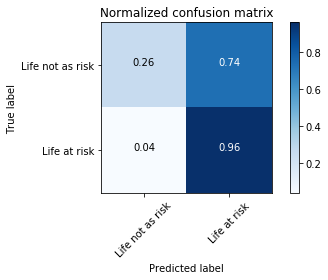

In [7]:
gauss_classifier = GaussianNB()

gaussParameters = {
  'priors':[None],
  'var_smoothing' :[1e-09]
}

gauss_classifier, default_gauss_score, tuned_gauss_score, cnf_gauss_matrix = model_utils.tune_classifier(gauss_classifier, gaussParameters,  X_train, X_test, y_train, y_test)

model_utils.plot_confusion_matrix(cnf_gauss_matrix, classes=['Life not as risk', 'Life at risk'], normalize = True)
print "Unoptimized model\n------"
print "F-score on testing data: {:.4f}".format(default_gauss_score)
print "\nOptimized Model\n------"
print "Final F-score on the testing data: {:.4f}".format(tuned_gauss_score)

joblib.dump(gauss_classifier, 'gauss_classifier.joblib') 


# Stacking
## Stacking with to best classifiers

/anaconda2/lib/python2.7/site-packages/mlxtend/classifier/stacking_classification.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X, y)
/anaconda2/lib/python2.7/site-packages/mlxtend/classifier/stacking_classification.py:171: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.meta_clf_.fit(meta_features, y)


F-score on validation data: 0.8054


StackingClassifier(average_probas=False,
          classifiers=[RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight...rithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=50, random_state=134)],
          meta_classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=134, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=True, 

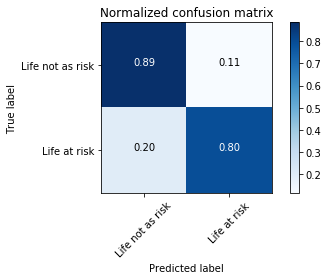

In [8]:
sclf_two, sclf_score = model_utils.get_stack_two(rf_classifier, ada_classifier, X_train, X_test, y_train, y_test, seed)

joblib.dump(sclf_two, 'sclf_two.joblib') 

model_utils.model_validation('sclf_two.joblib', X_test, y_test)

## Stacking with all classifiers

F-score on validation data: 0.8062


StackingClassifier(average_probas=False,
          classifiers=[RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight..._rate=1,
          n_estimators=50, random_state=134), GaussianNB(priors=None, var_smoothing=1e-09)],
          meta_classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=134, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=True, 

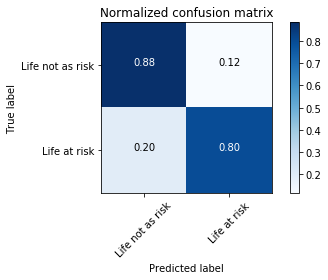

In [9]:
sclf_all, sclf_all_score = model_utils.get_stack_all(rf_classifier, ada_classifier, gauss_classifier, X_train, X_test, y_train, y_test, seed)

joblib.dump(sclf_all, 'sclf_all.joblib') 

model_utils.model_validation('sclf_all.joblib', X_test, y_test)